This notebook runs several models to predict whether posts are from the subreddit r/OCPoetry or r/shortscarystories.
The models use different feature sets (word counts, tfidf frequencies, whitespace, sentiment scores, part of speech tagging) and different classification algorithms (logistic regression, naive Bayes, and random forests).

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import FunctionTransformer, MaxAbsScaler

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion

from sklearn.metrics import ConfusionMatrixDisplay

#### Import and overview data

In [2]:
df = pd.read_parquet('data/data_cleaned.parquet')

In [3]:
df.head()

,title,text,auth,time,subreddit,new_line_chars,tab_chars,space_chars,zws_chars,title_words,...,(,),$,``,#,'',polarity,subjectivity,subjectivity_abs_dev,polarity_abs_dev
0,the moths of time,the moths of time consume your image; everythi...,lizerdqweenchlo,2022-01-26 23:33:47,OCPoetry,0.158273,0.0,0.964029,0.000000,4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.006944,0.516667,0.029958,0.045054
1,Haunted Houses,Floorboards creak Under little kid feet As a n...,richardcrack,2022-01-26 23:15:39,OCPoetry,0.515723,0.0,0.795597,0.053459,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.023633,0.371639,0.115069,0.028366
2,Forest of Eden,He could never quite find What made it paradis...,mgmgmgmgm,2022-01-26 22:43:59,OCPoetry,0.560000,0.0,0.920000,0.066667,3,...,0.0,0.0,0.0,0.0,0.0,0.0,-0.033333,0.500000,0.013292,0.085332
3,The deepest fluctuation of creativity,With due regard at your behest I'll smear the ...,puredreadful,2022-01-26 21:53:47,OCPoetry,0.390244,0.0,0.829268,0.024390,5,...,0.0,0.0,0.0,0.0,0.0,0.0,-0.085000,0.275000,0.211708,0.136999
4,A Heart Divided,"If I were two instead of just one, I could mak...",robbsmith711,2022-01-26 21:49:32,OCPoetry,0.062130,0.0,0.970414,0.000000,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.256528,0.753272,0.266563,0.204529


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56550 entries, 0 to 56549
Data columns (total 62 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   title                 56550 non-null  object        
 1   text                  56550 non-null  object        
 2   auth                  56550 non-null  object        
 3   time                  56550 non-null  datetime64[ns]
 4   subreddit             56550 non-null  object        
 5   new_line_chars        56550 non-null  float64       
 6   tab_chars             56550 non-null  float64       
 7   space_chars           56550 non-null  float64       
 8   zws_chars             56550 non-null  float64       
 9   title_words           56550 non-null  int64         
 10  text_words            56550 non-null  int64         
 11  word_count            56550 non-null  int64         
 12  title_text            56550 non-null  object        
 13  CC              

The text and title columns have a few NAs but that is okay since we will only use the merged `title_text` column as a feature which does not have NAs.

In [5]:
df.columns[df.isna().any()]

Index([], dtype='object')

#### Baseline model

Our data set is balanced. For balanced datasets accuracy is a reasonable metric and a baseline model scores about 50%.

In [6]:
y = df['subreddit']
y.value_counts(normalize = True)

OCPoetry             0.50603
shortscarystories    0.49397
Name: subreddit, dtype: float64

### Text only models

##### Train, test split data

In [7]:
X = df['title_text']
y = df['subreddit']

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

##### Run model function

In [9]:
def run_model(model, X_train = X_train, X_test = X_test, y_train = y_train, y_test = y_test):
    model.fit(X_train, y_train)
    print(f"Training score: {model.score(X_train, y_train):.3f}")
    print(f"Testing score: {model.score(X_test, y_test):.3f}")

##### Feature ranking functions

In [10]:
def display_top_features(feature_series):
    print("=== Top features for OCPoetry ===")
    print(feature_series.sort_values().head(10))
    print()
    print("=== Top features for shortscarystories ===")
    print(feature_series.sort_values(ascending=False).head(10))

In [11]:
def top_coefs_lr(lr_model):
    lr_coefs = lr_model.coef_
    features = lr_model.feature_names_in_
    lr_coefs_series = pd.Series(lr_coefs[0], index = features)

    display_top_features(lr_coefs_series)

In [12]:
def top_coefs_lr_pipe(lr_pipe):
    lr_coefs = lr_pipe.named_steps['logisticregression'].coef_
    features = lr_pipe.named_steps['tfidfvectorizer'].get_feature_names_out()
    lr_coefs_series = pd.Series(lr_coefs[0], index = features)

    display_top_features(lr_coefs_series)

#### Model 1
* Text features only
* Tfidf vectorizer
* logistic regression

Note that a MaxAbsScaler is used because it works well with sparse out put from the Tfidf Vectorizer

In [13]:
pipe1 = make_pipeline(
    TfidfVectorizer(max_features = 1000),
    MaxAbsScaler(),
    LogisticRegression(max_iter = 10_000, solver = 'saga', warm_start = True)
)

The model scores 91.3% accuracy on the training set and is overfitting by about 1%.

In [14]:
run_model(pipe1)

Training score: 0.924
Testing score: 0.913


##### Top features

In [15]:
top_coefs_lr_pipe(pipe1)

=== Top features for OCPoetry ===
feedback   -12.037625
poem       -11.312260
poetry      -6.673354
heart       -4.331140
wrote       -3.551745
in          -3.479486
like        -2.992899
yet         -2.909161
lines       -2.731072
love        -2.675275
dtype: float64

=== Top features for shortscarystories ===
horror         5.127167
story          3.994172
stories        3.663051
was            3.444374
immediately    3.310995
police         3.261500
basement       3.191972
it             3.125241
killed         3.055125
people         2.973666
dtype: float64


##### Cross Validation

The LogisticRegressionCV model takes about 6-7 times longer to run. Since they don't give significantly different answers for C > 1, I will leave it at the default value (c = 1) for most models.

In [16]:
pipe1_cv = make_pipeline(
    TfidfVectorizer(max_features = 1000),
    MaxAbsScaler(),
    LogisticRegressionCV(max_iter = 10_000, solver  = 'saga')
)
run_model(pipe1_cv)

Training score: 0.928
Testing score: 0.913


In [17]:
pipe1_cv.named_steps['logisticregressioncv'].C_

array([166.81005372])

In [18]:
pipe1_cv.named_steps['logisticregressioncv'].Cs_

array([1.00000000e-04, 7.74263683e-04, 5.99484250e-03, 4.64158883e-02,
       3.59381366e-01, 2.78255940e+00, 2.15443469e+01, 1.66810054e+02,
       1.29154967e+03, 1.00000000e+04])

In [19]:
pipe1_cv.named_steps['logisticregressioncv'].scores_['shortscarystories']

array([[0.81586703, 0.85028881, 0.87091831, 0.90086054, 0.9217258 ,
        0.92455499, 0.92679477, 0.92644112, 0.9258517 , 0.9258517 ],
       [0.80938347, 0.83626076, 0.85677237, 0.88753979, 0.90746198,
        0.91264883, 0.91253094, 0.91241306, 0.91241306, 0.91241306],
       [0.80464513, 0.8382457 , 0.86135345, 0.89177081, 0.90980901,
        0.91275643, 0.91346381, 0.91405329, 0.9138175 , 0.9138175 ],
       [0.81714218, 0.8416647 , 0.8632398 , 0.89636878, 0.91546805,
        0.91853336, 0.9171186 , 0.9173544 , 0.9172365 , 0.9173544 ],
       [0.80995048, 0.83718463, 0.85934921, 0.89294978, 0.91075218,
        0.91322801, 0.91216694, 0.91228484, 0.91240274, 0.91240274]])

#### Model 2 - Logistic regression with stop words

We should add some stop words that might make this task too easy by giving away the answer directly: poem / poetry, feedback, story and stories.
Note that the word 'feedback' is present overwhelmingly in r/OCPoetry because of a rule that each submission include links to 2 of the author's comments giving feedback to other posts.
These links are often put in a section labeled feedback, for example like this https://www.reddit.com/r/OCPoetry/comments/sevmm6/tell_daisy/.

In [20]:
stop_words = ['poem', 'poems', 'ocpoetry', 'poet', 'poets', 'poetry', 'link', 'links', 'feedback', 'story', 'stories']

In [21]:
pipe2 = make_pipeline(
    TfidfVectorizer(max_features = 1000, stop_words=stop_words),
    MaxAbsScaler(),
    LogisticRegression(max_iter = 10_000, solver = 'saga', warm_start = True)
)

Compared to the previous model, taking out stop words reduced the model accuracy by about 0.5% on both the test and training set.

In [22]:
run_model(pipe2)

Training score: 0.917
Testing score: 0.907


##### Top features

In [23]:
top_coefs_lr_pipe(pipe2)

=== Top features for OCPoetry ===
wrote    -4.920941
heart    -4.531349
in       -3.481216
yet      -3.144788
lines    -3.010759
like     -2.966011
love     -2.821241
write    -2.705977
tears    -2.621535
beauty   -2.606099
dtype: float64

=== Top features for shortscarystories ===
horror         6.734071
was            3.567471
short          3.509582
immediately    3.453581
police         3.380810
basement       3.241785
killed         3.088144
it             3.070294
people         3.054826
normal         3.045111
dtype: float64


#### Naive Bayes Model

In [24]:
pipe3 = make_pipeline(
    TfidfVectorizer(max_features = 1000, stop_words=stop_words),
    MaxAbsScaler(),
    MultinomialNB()
)

In [25]:
run_model(pipe3)

Training score: 0.855
Testing score: 0.856


This ranks the importance of features in a Naive Bayes model by taking the difference of the log-odds of feature appearing in one sub reddit versus the other.

In [26]:
def top_features_nb(nb_pipe):
    nb_log_odds = nb_pipe.named_steps['multinomialnb'].feature_log_prob_
    features = nb_pipe.named_steps['tfidfvectorizer'].get_feature_names_out()
    classes = nb_pipe.named_steps['multinomialnb'].classes_
    nb_log_odds_df = pd.DataFrame(nb_log_odds.T, index = features, columns = classes)

    # print(nb_log_odds_df.head())
    log_odds_diff = nb_log_odds_df['OCPoetry'] - nb_log_odds_df['shortscarystories']
    print("=== Top features for OCPoetry ===")
    print(log_odds_diff.sort_values(ascending = False).head(10))
    print()
    print("=== Top features for shortscarystories ===")
    print(log_odds_diff.sort_values().head(10))

In [27]:
top_features_nb(pipe3)

=== Top features for OCPoetry ===
lies      1.993306
beauty    1.991780
dance     1.825713
amp       1.816486
sea       1.754919
wrote     1.659528
fly       1.635383
lines     1.628444
stars     1.597872
love      1.585213
dtype: float64

=== Top features for shortscarystories ===
immediately   -2.649222
grabbed       -2.526056
police        -2.236366
hallway       -2.174541
basement      -2.100894
screamed      -2.054198
mommy         -1.992400
mr            -1.965775
noticed       -1.910459
continued     -1.863802
dtype: float64


The Naive Bayes model is picking up an additional words that should be removed: amp. I'm not sure exactly what this is but it is used in formatting primarily for r/OCPoetry.

In [28]:
stop_words.append('amp')

#### Rerun models with full stop words

In [29]:
pipe_lr_4 = make_pipeline(
    TfidfVectorizer(max_features = 1000, stop_words=stop_words),
    MaxAbsScaler(),
    LogisticRegression(max_iter = 10_000, solver = 'saga', warm_start = True)
)

pipe_mnb_4 = make_pipeline(
    TfidfVectorizer(max_features = 1000, stop_words=stop_words),
    MaxAbsScaler(),
    MultinomialNB()
)

In [30]:
run_model(pipe_lr_4)
top_coefs_lr_pipe(pipe_lr_4)

Training score: 0.916
Testing score: 0.908
=== Top features for OCPoetry ===
wrote    -4.921162
heart    -4.562286
in       -3.506538
yet      -3.125402
lines    -3.101091
like     -2.972417
love     -2.816242
write    -2.720307
tears    -2.645069
beauty   -2.631192
dtype: float64

=== Top features for shortscarystories ===
horror         6.741139
was            3.580709
short          3.506101
immediately    3.443394
police         3.408741
basement       3.256193
killed         3.099632
people         3.080351
it             3.079355
normal         3.064435
dtype: float64


In [31]:
run_model(pipe_mnb_4)
top_features_nb(pipe_mnb_4)

Training score: 0.854
Testing score: 0.856
=== Top features for OCPoetry ===
lies       1.993838
beauty     1.989419
dance      1.826234
sea        1.756161
wrote      1.659703
fly        1.637861
lines      1.629195
stars      1.598677
flowers    1.586283
love       1.585677
dtype: float64

=== Top features for shortscarystories ===
immediately   -2.642404
grabbed       -2.526920
police        -2.236521
hallway       -2.167739
basement      -2.095728
screamed      -2.054749
mommy         -1.992926
mr            -1.964524
noticed       -1.911430
continued     -1.864214
dtype: float64


There is some overlap in the top features for the two models but many major differences: for instance the word "was" is the #1 feature for the logistic regression model for the shortscarystories class but not in the top 10 for the naive-Bayes model. Note that I won't compare the magnitudes of scores (only the rankings) between the two models because they represent different quantites (coefficients for the logistic regression model vs log-probabilities for the naive-Bayes model).

#### Random forest model

In [32]:
pipe_rf_5 = make_pipeline(
    TfidfVectorizer(max_features = 1000, stop_words = stop_words),
    RandomForestClassifier(min_samples_split=40)
)

Random forest models are significantly slower to train than either naive-Bayes or logistic regression and they are extremely overfit.

In [33]:
run_model(pipe_rf_5)

Training score: 0.980
Testing score: 0.871


#### Extra Trees Classifier

Since randomized forest models overfit the dataset I tried an Extra Trees classifier but this didn't help much.

In [34]:
pipe_et_6 = make_pipeline(
    TfidfVectorizer(max_features = 1000, stop_words = stop_words),
    ExtraTreesClassifier(min_samples_split=40, n_jobs = -1)
)

In [35]:
run_model(pipe_et_6)

Training score: 0.996
Testing score: 0.879


In [36]:
pipe_et_7 = make_pipeline(
    TfidfVectorizer(max_features = 1000, stop_words = stop_words),
    ExtraTreesClassifier(min_samples_split=100, n_jobs = -1)
)

In [37]:
run_model(pipe_et_7)

Training score: 0.972
Testing score: 0.874


#### Larger Tfidf vector
As expected increasing the max_features parameter increases the accuracy. 
The logistic regression accuracy improved from 0.908 to 0.923 and the naive bayes model accuracy improved from 0.856 to 0.891.

In [38]:
pipe_lr_7 = make_pipeline(
    TfidfVectorizer(max_features = 5000, stop_words=stop_words),
    MaxAbsScaler(),
    LogisticRegression(max_iter = 10_000, solver = 'saga', warm_start = True)
)

pipe_mnb_7 = make_pipeline(
    TfidfVectorizer(max_features = 5000, stop_words=stop_words),
    MaxAbsScaler(),
    MultinomialNB()
)


In [39]:
run_model(pipe_lr_7)
top_coefs_lr_pipe(pipe_lr_7)

Training score: 0.950
Testing score: 0.923
=== Top features for OCPoetry ===
wrote         -3.646506
heart         -3.396637
comment       -2.671619
appreciated   -2.609973
write         -2.579816
lost          -2.508521
like          -2.500696
by            -2.493230
context       -2.483748
yet           -2.435211
dtype: float64

=== Top features for shortscarystories ===
horror       4.632961
scary        4.156407
people       2.981689
short        2.975123
was          2.965614
halloween    2.941921
creepy       2.911811
horrible     2.861187
000          2.782803
blood        2.759967
dtype: float64


In [40]:
run_model(pipe_mnb_7)
top_features_nb(pipe_mnb_7)

Training score: 0.889
Testing score: 0.891
=== Top features for OCPoetry ===
haiku        4.023383
sonnet       3.836621
critique     3.265102
ode          3.240962
strife       3.024006
verse        2.781688
dew          2.768746
criticism    2.623925
rhymes       2.586109
bloom        2.579035
dtype: float64

=== Top features for shortscarystories ===
250           -2.924117
sprinted      -2.814273
downstairs    -2.806918
shrugged      -2.784462
911           -2.751644
freaked       -2.708616
detective     -2.692527
officer       -2.682599
immediately   -2.680528
nodded        -2.623328
dtype: float64


#### Count vectorization

In [41]:
pipe_lr_8 = make_pipeline(
    CountVectorizer(max_features = 1000, stop_words=stop_words),
    MaxAbsScaler(),
    LogisticRegression(max_iter = 10_000, solver = 'saga', warm_start = True)
)

pipe_mnb_8 = make_pipeline(
    CountVectorizer(max_features = 1000, stop_words=stop_words),
    MaxAbsScaler(),
    MultinomialNB()
)


Compared to the tfidf vectorizer the logistic regression performed worse (0.901 vs 0.908) and the naive Bayes model did slightly better (0.857 vs 0.856).

In [42]:
run_model(pipe_lr_8)
# top_coefs_lr_pipe(pipe_lr_8)

Training score: 0.910
Testing score: 0.901


In [43]:
run_model(pipe_mnb_8)
# top_features_nb(pipe_mnb_8)

Training score: 0.854
Testing score: 0.857


### Other features

For comparing feature sets I will stick with logistic regression models as they are fast to train and one of the most accuracte models in the previous section. Additionally, I will use no penalty term as these are small feature sets and overfitting is not a concern.

In [44]:
df.columns

Index(['title', 'text', 'auth', 'time', 'subreddit', 'new_line_chars',
       'tab_chars', 'space_chars', 'zws_chars', 'title_words', 'text_words',
       'word_count', 'title_text', 'CC', 'CD', 'DT', 'EX', 'FW', 'IN', 'JJ',
       'JJR', 'JJS', 'LS', 'MD', 'NN', 'NNS', 'NNP', 'NNPS', 'PDT', 'POS',
       'PRP', 'PRP$', 'RB', 'RBR', 'RBS', 'RP', 'SYM', 'TO', 'UH', 'VB', 'VBD',
       'VBG', 'VBN', 'VBP', 'VBZ', 'WDT', 'WP', 'WP$', 'WRB', '.', ',', ':',
       '(', ')', '$', '``', '#', '''', 'polarity', 'subjectivity',
       'subjectivity_abs_dev', 'polarity_abs_dev'],
      dtype='object')

In [45]:
X = df.drop(columns = ['title', 'text', 'auth', 'time', 'subreddit'])
y = df['subreddit']

#### White space features

In [46]:
X_ws = X[['new_line_chars', 'tab_chars', 'space_chars', 'zws_chars']]
X_ws_train, X_ws_test, y_train, y_test = train_test_split(X_ws, y)

ws_model = LogisticRegression(solver = 'saga', max_iter=1_000, penalty='none')
run_model(ws_model, X_ws_train, X_ws_test, y_train, y_test)

Training score: 0.908
Testing score: 0.910


A model trained on average white space alone is incredibly powerful at 90.9% accuracy, nearly identical to the tfidf vectorization model score.

In [47]:
top_coefs_lr(ws_model)

=== Top features for OCPoetry ===
new_line_chars   -21.005176
space_chars       -3.706502
tab_chars         -0.034591
zws_chars          1.131805
dtype: float64

=== Top features for shortscarystories ===
zws_chars          1.131805
tab_chars         -0.034591
space_chars       -3.706502
new_line_chars   -21.005176
dtype: float64


#### Line break characters

Most of the power in the white space model came from new line characters - which alone achieved 90% accuracy.

In [48]:
X_lb = X[['new_line_chars']]
X_lb_train, X_lb_test, y_train, y_test = train_test_split(X_lb, y)

lb_model = LogisticRegression(solver = 'saga', max_iter = 1_000, penalty='none')
run_model(lb_model, X_lb_train, X_lb_test, y_train, y_test)

Training score: 0.903
Testing score: 0.902


In [49]:
lb_model.coef_

array([[-20.01077195]])

#### Parts of speech words only:

In [50]:
X_pos_words = X.loc[:, 'CC':'WRB']
X_pos_words.head()

,CC,CD,DT,EX,FW,IN,JJ,JJR,JJS,LS,...,VB,VBD,VBG,VBN,VBP,VBZ,WDT,WP,WP$,WRB
0,0.034965,0.000000,0.090909,0.013986,0.0,0.139860,0.069930,0.000000,0.000000,0.0,...,0.034965,0.020979,0.027972,0.006993,0.006993,0.048951,0.020979,0.000000,0.000000,0.020979
1,0.037500,0.006250,0.121875,0.003125,0.0,0.078125,0.096875,0.000000,0.000000,0.0,...,0.065625,0.034375,0.006250,0.031250,0.028125,0.021875,0.000000,0.003125,0.000000,0.009375
2,0.064103,0.000000,0.141026,0.000000,0.0,0.089744,0.012821,0.000000,0.000000,0.0,...,0.038462,0.076923,0.012821,0.025641,0.012821,0.051282,0.012821,0.012821,0.000000,0.000000
3,0.086957,0.000000,0.130435,0.000000,0.0,0.108696,0.086957,0.000000,0.043478,0.0,...,0.065217,0.021739,0.000000,0.021739,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.046921,0.032258,0.102639,0.000000,0.0,0.105572,0.052786,0.005865,0.002933,0.0,...,0.052786,0.023460,0.011730,0.032258,0.041056,0.032258,0.005865,0.008798,0.002933,0.008798


Using parts of speech for the words alone gives more than 75% accuracy.

In [51]:
X_pos_words_train, X_pos_words_test, y_train, y_test = train_test_split(X_pos_words, y)
pos_words_model = LogisticRegression(solver = 'saga', max_iter=10000, penalty='none')
run_model(pos_words_model, X_pos_words_train, X_pos_words_test, y_train, y_test)

Training score: 0.781
Testing score: 0.776


The parts of speech most indicative of r/OCPoetry are
* WP$ - wh-pronoun, possessive
* PDT - predeterminer
* WDT - wh-determiner
* NNPS - Noun, proper plural
* FW - foreign word
* WRB - wh-adverbs
* VBP - verb, non-third person singular present

The coefficients for the top features indicative of r/shortscarystories are much larger in magnitude. These are
* UH - interjection
* RBS - adverb superlative
* RP - adverb particle
* VBD - verb, past tense
* CD - cardinal number

The full set of codes with examples are available [here](https://ericthornton.net/NLP-3/ref_nlp_penn_treebank2_pos_tags_list.php).

In [52]:
top_coefs_lr(pos_words_model)

=== Top features for OCPoetry ===
WP$    -37.404944
PDT    -33.253315
FW     -13.774780
NNPS   -12.441442
WDT    -11.931092
WRB     -3.324410
NNS      0.236422
VBP      0.265308
NN       0.295517
NNP      1.071429
dtype: float64

=== Top features for shortscarystories ===
UH     60.480832
RP     45.102590
RBS    44.988755
VBD    33.622909
SYM    32.746047
CD     28.022512
DT     22.471586
EX     22.126166
JJS    18.995177
VBG    18.667828
dtype: float64


#### Parts of speech words and punctuation

I think some of the punctuation (for example semicolons) might be part of the display formatting in addition to the post content so take these scores with a grain of salt.

In [53]:
X_pos = X.loc[:, 'CC':"''"]
X_pos.head()

,CC,CD,DT,EX,FW,IN,JJ,JJR,JJS,LS,...,WRB,.,",",:,(,),$,``,#,''
0,0.034965,0.000000,0.090909,0.013986,0.0,0.139860,0.069930,0.000000,0.000000,0.0,...,0.020979,0.069930,0.034965,0.013986,0.0,0.0,0.0,0.0,0.0,0.0
1,0.037500,0.006250,0.121875,0.003125,0.0,0.078125,0.096875,0.000000,0.000000,0.0,...,0.009375,0.012500,0.078125,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,0.064103,0.000000,0.141026,0.000000,0.0,0.089744,0.012821,0.000000,0.000000,0.0,...,0.000000,0.064103,0.089744,0.012821,0.0,0.0,0.0,0.0,0.0,0.0
3,0.086957,0.000000,0.130435,0.000000,0.0,0.108696,0.086957,0.000000,0.043478,0.0,...,0.000000,0.021739,0.043478,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,0.046921,0.032258,0.102639,0.000000,0.0,0.105572,0.052786,0.005865,0.002933,0.0,...,0.008798,0.049853,0.041056,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


When punctuation is added the model accuracy increases to 82.7%.

In [54]:
X_pos_train, X_pos_test, y_train, y_test = train_test_split(X_pos, y)
pos_model = LogisticRegression(solver = 'saga', max_iter=10000, penalty = 'none')
run_model(pos_model, X_pos_train, X_pos_test, y_train, y_test)

Training score: 0.825
Testing score: 0.830


Punctuation that is indicative of r/OCPoetry are colons, parentheses, and commas while '.' (any sentence ending punctuation including semicolon, question mark and asterik) is indicative of r/shortscarystories.

In [55]:
top_coefs_lr(pos_model)

=== Top features for OCPoetry ===
PDT    -26.603900
)      -18.595669
WP$    -11.921533
(      -11.602885
:      -10.210653
NNPS    -7.122741
WDT     -4.090550
,       -3.404712
NNS     -2.294215
WP      -1.869267
dtype: float64

=== Top features for shortscarystories ===
SYM    61.189710
RBS    48.406086
RP     43.596306
VBD    32.634892
CD     28.396462
.      23.363808
TO     23.349770
''     21.804615
UH     21.685121
JJS    20.142304
dtype: float64


#### Sentiment

In [56]:
X_sentiment = X.loc[:, 'polarity':]
X_sentiment.head()

,polarity,subjectivity,subjectivity_abs_dev,polarity_abs_dev
0,0.006944,0.516667,0.029958,0.045054
1,0.023633,0.371639,0.115069,0.028366
2,-0.033333,0.500000,0.013292,0.085332
3,-0.085000,0.275000,0.211708,0.136999
4,0.256528,0.753272,0.266563,0.204529


In [57]:
X_sentiment_train, X_sentiment_test, y_train, y_test = train_test_split(X_sentiment, y)
sentiment_model = LogisticRegression(solver = 'saga', penalty = 'none', max_iter = 1000)
run_model(sentiment_model, X_sentiment_train, X_sentiment_test, y_train, y_test)

Training score: 0.638
Testing score: 0.643


As expected in the feature engineering notebook, higher absolute deviation scores for subjectivity and polarity are both decent predictors of r/OCPoetry.

In [58]:
top_coefs_lr(sentiment_model)

=== Top features for OCPoetry ===
subjectivity_abs_dev   -4.939392
polarity_abs_dev       -3.593634
polarity               -1.665226
subjectivity           -1.052128
dtype: float64

=== Top features for shortscarystories ===
subjectivity           -1.052128
polarity               -1.665226
polarity_abs_dev       -3.593634
subjectivity_abs_dev   -4.939392
dtype: float64


#### Word length

In [77]:
X_len = X[['title_words', 'text_words']]

In [79]:
X_len_train, X_len_test, y_train, y_test = train_test_split(X_len, y)
len_model = LogisticRegression(solver = 'saga', penalty = 'none', max_iter = 1000)
run_model(len_model, X_len_train, X_len_test, y_train, y_test)

Training score: 0.673
Testing score: 0.678


In [80]:
top_coefs_lr(len_model)

=== Top features for OCPoetry ===
title_words   -0.125606
text_words     0.004062
dtype: float64

=== Top features for shortscarystories ===
text_words     0.004062
title_words   -0.125606
dtype: float64


### Text + Other Feature models

In [59]:
X.columns

Index(['new_line_chars', 'tab_chars', 'space_chars', 'zws_chars',
       'title_words', 'text_words', 'word_count', 'title_text', 'CC', 'CD',
       'DT', 'EX', 'FW', 'IN', 'JJ', 'JJR', 'JJS', 'LS', 'MD', 'NN', 'NNS',
       'NNP', 'NNPS', 'PDT', 'POS', 'PRP', 'PRP$', 'RB', 'RBR', 'RBS', 'RP',
       'SYM', 'TO', 'UH', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'WDT', 'WP',
       'WP$', 'WRB', '.', ',', ':', '(', ')', '$', '``', '#', '''', 'polarity',
       'subjectivity', 'subjectivity_abs_dev', 'polarity_abs_dev'],
      dtype='object')

Stopwords relisted:

In [60]:
stop_words = [
    'poem',
    'poems',
    'ocpoetry',
    'poet',
    'poets',
    'poetry',
    'link',
    'links',
    'feedback',
    'story',
    'stories',
    'amp'
]

['poem',
 'poems',
 'ocpoetry',
 'poet',
 'poets',
 'poetry',
 'link',
 'links',
 'feedback',
 'story',
 'stories',
 'amp']

Function to get top features from a pipeline with a column transformer.

In [61]:
def top_coefs_lr_pipe_ct(lr_pipe):
    lr_coefs = lr_pipe.named_steps['logisticregression'].coef_
    features = lr_pipe.named_steps['columntransformer'].get_feature_names_out()
    lr_coefs_series = pd.Series(lr_coefs[0], index = features)

    display_top_features(lr_coefs_series)

Earlier our logistic regression model with the full set of stop words and 1000 max features scored 90.5% accuracy. Let's see if adding the other features improves the accuracy.

#### Text + white space

In [62]:
X_text_ws = X[['title_text', 'new_line_chars', 'tab_chars', 'space_chars', 'zws_chars']]

In [63]:
X_text_ws_train, X_text_ws_test, y_train, y_test = train_test_split(X_text_ws, y)

tfidf_ws_model = make_pipeline(
    make_column_transformer(
        (TfidfVectorizer(max_features=1000, stop_words = stop_words), 'title_text'),
        remainder = 'passthrough',
        verbose_feature_names_out = False
    ),
    MaxAbsScaler(),
    LogisticRegression(solver = 'saga', max_iter = 10_000)
)

run_model(tfidf_ws_model, X_text_ws_train, X_text_ws_test, y_train, y_test)

Training score: 0.950
Testing score: 0.942


Here the model accuracy has increased to 94.4% (4% above text alone).
New line characters are now the most important feature for the r/OCPoetry class.

In [64]:
top_coefs_lr_pipe_ct(tfidf_ws_model)

=== Top features for OCPoetry ===
new_line_chars   -40.666970
in                -3.827819
wrote             -3.715967
heart             -3.607654
space_chars       -3.197771
on                -2.789489
tears             -2.771591
like              -2.559365
lost              -2.501376
thoughts          -2.491645
dtype: float64

=== Top features for shortscarystories ===
horror         5.390850
immediately    3.368985
police         3.171657
woods          3.086173
creature       2.889418
10             2.871255
basement       2.757289
humans         2.692898
it             2.627196
going          2.497763
dtype: float64


#### Text + Parts of speech words

In [65]:
X_text_pos_words = pd.merge(X[['title_text']], X.loc[:, 'CC': 'WRB'], left_index=True, right_index=True)
X_text_pos_words.head()

,title_text,CC,CD,DT,EX,FW,IN,JJ,JJR,JJS,...,VB,VBD,VBG,VBN,VBP,VBZ,WDT,WP,WP$,WRB
0,the moths of timethe moths of time consume you...,0.034965,0.000000,0.090909,0.013986,0.0,0.139860,0.069930,0.000000,0.000000,...,0.034965,0.020979,0.027972,0.006993,0.006993,0.048951,0.020979,0.000000,0.000000,0.020979
1,Haunted HousesFloorboards creak Under little k...,0.037500,0.006250,0.121875,0.003125,0.0,0.078125,0.096875,0.000000,0.000000,...,0.065625,0.034375,0.006250,0.031250,0.028125,0.021875,0.000000,0.003125,0.000000,0.009375
2,Forest of EdenHe could never quite find What m...,0.064103,0.000000,0.141026,0.000000,0.0,0.089744,0.012821,0.000000,0.000000,...,0.038462,0.076923,0.012821,0.025641,0.012821,0.051282,0.012821,0.012821,0.000000,0.000000
3,The deepest fluctuation of creativityWith due ...,0.086957,0.000000,0.130435,0.000000,0.0,0.108696,0.086957,0.000000,0.043478,...,0.065217,0.021739,0.000000,0.021739,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,A Heart DividedIf I were two instead of just o...,0.046921,0.032258,0.102639,0.000000,0.0,0.105572,0.052786,0.005865,0.002933,...,0.052786,0.023460,0.011730,0.032258,0.041056,0.032258,0.005865,0.008798,0.002933,0.008798


In [66]:
X_text_pos_words_train, X_text_pos_words_test, y_train, y_test = train_test_split(X_text_pos_words, y)

tfidf_pos_words_model = make_pipeline(
    make_column_transformer(
        (TfidfVectorizer(max_features=1000, stop_words = stop_words), 'title_text'),
        remainder = 'passthrough',
        verbose_feature_names_out = False
    ),
    MaxAbsScaler(),
    LogisticRegression(solver = 'saga', max_iter = 10_000)
)

run_model(tfidf_pos_words_model, X_text_pos_words_train, X_text_pos_words_test, y_train, y_test)

Training score: 0.919
Testing score: 0.913


Adding parts of speech didn't improve the accuracy scores much, although the model is a bit more overfit.
One new feature (CD for cardinal numbers) is a top predictor for the r/shortscarystories class.

In [67]:
top_coefs_lr_pipe_ct(tfidf_pos_words_model)

=== Top features for OCPoetry ===
wrote    -5.250292
heart    -4.091023
yet      -3.040635
in       -2.867425
tears    -2.829278
beauty   -2.772554
too      -2.644396
self     -2.598258
hold     -2.572093
how      -2.517427
dtype: float64

=== Top features for shortscarystories ===
horror         6.855577
CD             4.177349
people         3.776545
woods          3.706782
short          3.474840
immediately    3.448027
police         3.329630
the            3.174981
blood          3.164818
basement       3.100818
dtype: float64


#### Text + Parts of Speech

In [68]:
X_text_pos = pd.merge(X[['title_text']], X.loc[:, 'CC': "''"], left_index=True, right_index=True)
X_text_pos.head()

,title_text,CC,CD,DT,EX,FW,IN,JJ,JJR,JJS,...,WRB,.,",",:,(,),$,``,#,''
0,the moths of timethe moths of time consume you...,0.034965,0.000000,0.090909,0.013986,0.0,0.139860,0.069930,0.000000,0.000000,...,0.020979,0.069930,0.034965,0.013986,0.0,0.0,0.0,0.0,0.0,0.0
1,Haunted HousesFloorboards creak Under little k...,0.037500,0.006250,0.121875,0.003125,0.0,0.078125,0.096875,0.000000,0.000000,...,0.009375,0.012500,0.078125,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,Forest of EdenHe could never quite find What m...,0.064103,0.000000,0.141026,0.000000,0.0,0.089744,0.012821,0.000000,0.000000,...,0.000000,0.064103,0.089744,0.012821,0.0,0.0,0.0,0.0,0.0,0.0
3,The deepest fluctuation of creativityWith due ...,0.086957,0.000000,0.130435,0.000000,0.0,0.108696,0.086957,0.000000,0.043478,...,0.000000,0.021739,0.043478,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,A Heart DividedIf I were two instead of just o...,0.046921,0.032258,0.102639,0.000000,0.0,0.105572,0.052786,0.005865,0.002933,...,0.008798,0.049853,0.041056,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


In [69]:
X_text_pos_train, X_text_pos_test, y_train, y_test = train_test_split(X_text_pos, y)

tfidf_pos_model = make_pipeline(
    make_column_transformer(
        (TfidfVectorizer(max_features=1000, stop_words = stop_words), 'title_text'),
        remainder = 'passthrough',
        verbose_feature_names_out = False
    ),
    MaxAbsScaler(),
    LogisticRegression(solver = 'saga', max_iter = 10_000)
)

run_model(tfidf_pos_model, X_text_pos_train, X_text_pos_test, y_train, y_test)

Training score: 0.926
Testing score: 0.919


Adding puctuation improved the accuracy to 91.9%, 1% better than text features alone.
Several punctuation categories are considered important predictors.

In [70]:
top_coefs_lr_pipe_ct(tfidf_pos_model)

=== Top features for OCPoetry ===
wrote      -3.934112
:          -3.311919
yet        -3.209056
heart      -3.058565
too        -2.961161
NN         -2.861498
hold       -2.806737
thoughts   -2.779332
how        -2.740932
sun        -2.675523
dtype: float64

=== Top features for shortscarystories ===
.              12.297766
horror          7.249787
police          3.524063
immediately     3.481813
blood           3.393138
people          3.322424
short           3.267682
CD              3.203260
kill            2.955705
anyone          2.929604
dtype: float64


#### Text + Sentiments

In [71]:
X_text_sentiment = X[['title_text', 'subjectivity', 'polarity', 'subjectivity_abs_dev', 'polarity_abs_dev']]
X_text_sentiment.head()

,title_text,subjectivity,polarity,subjectivity_abs_dev,polarity_abs_dev
0,the moths of timethe moths of time consume you...,0.516667,0.006944,0.029958,0.045054
1,Haunted HousesFloorboards creak Under little k...,0.371639,0.023633,0.115069,0.028366
2,Forest of EdenHe could never quite find What m...,0.500000,-0.033333,0.013292,0.085332
3,The deepest fluctuation of creativityWith due ...,0.275000,-0.085000,0.211708,0.136999
4,A Heart DividedIf I were two instead of just o...,0.753272,0.256528,0.266563,0.204529


In [72]:
X_text_sentiment_train, X_text_sentiment_test, y_train, y_test = train_test_split(X_text_sentiment, y)

tfidf_sentiment_model = make_pipeline(
    make_column_transformer(
        (TfidfVectorizer(max_features=1000, stop_words = stop_words), 'title_text'),
        remainder = 'passthrough',
        verbose_feature_names_out = False
    ),
    MaxAbsScaler(),
    LogisticRegression(solver = 'saga', max_iter = 10_000)
)

run_model(tfidf_sentiment_model, X_text_sentiment_train, X_text_sentiment_test, y_train, y_test)

Training score: 0.917
Testing score: 0.910


Adding sentiment scores did not improve the model at all.

In [73]:
top_coefs_lr_pipe_ct(tfidf_sentiment_model)

=== Top features for OCPoetry ===
heart    -4.272049
wrote    -4.157044
in       -3.619239
lines    -3.029128
yet      -2.922951
write    -2.909054
hold     -2.795991
beauty   -2.772525
like     -2.632382
broken   -2.624433
dtype: float64

=== Top features for shortscarystories ===
horror         6.960576
immediately    3.920164
was            3.827585
short          3.383369
police         3.323896
people         3.235936
creature       3.066061
mommy          3.054932
basement       3.030434
however        3.006283
dtype: float64


#### Text + Word counts

In [81]:
X_text_len = X[['title_text', 'text_words', 'title_words']]
X_text_len.head()

,title_text,text_words,title_words
0,the moths of timethe moths of time consume you...,138,4
1,Haunted HousesFloorboards creak Under little k...,317,2
2,Forest of EdenHe could never quite find What m...,74,3
3,The deepest fluctuation of creativityWith due ...,40,5
4,A Heart DividedIf I were two instead of just o...,337,3


In [82]:
X_text_len_train, X_text_len_test, y_train, y_test = train_test_split(X_text_len, y)

tfidf_len_model = make_pipeline(
    make_column_transformer(
        (TfidfVectorizer(max_features=1000, stop_words = stop_words), 'title_text'),
        remainder = 'passthrough',
        verbose_feature_names_out = False
    ),
    MaxAbsScaler(),
    LogisticRegression(solver = 'saga', max_iter = 10_000)
)

run_model(tfidf_len_model, X_text_len_train, X_text_len_test, y_train, y_test)

Training score: 0.919
Testing score: 0.909


Adding word lengths also did not improve the model much, even though text_words was a top feature for r/shortscarystories.

In [83]:
top_coefs_lr_pipe_ct(tfidf_len_model)

=== Top features for OCPoetry ===
wrote      -4.793735
heart      -4.129321
in         -4.095815
yet        -3.223627
like       -3.015009
lies       -2.978029
beauty     -2.944950
thoughts   -2.764993
tears      -2.760192
on         -2.684196
dtype: float64

=== Top features for shortscarystories ===
text_words     8.492802
horror         6.593044
immediately    3.837194
police         3.773925
was            3.513856
people         3.066337
short          3.047620
however        2.995588
humans         2.995524
mommy          2.961199
dtype: float64


### All features

In [ ]:
X_all_train, X_all_test, y_train, y_test = train_test_split(X, y)

In [86]:
tfidf_all_features_model = make_pipeline(
    make_column_transformer(
        (TfidfVectorizer(max_features=1000, stop_words = stop_words), 'title_text'),
        remainder = 'passthrough',
        verbose_feature_names_out = False
    ),
    MaxAbsScaler(),
    LogisticRegression(solver = 'saga', max_iter = 10_000)
)

run_model(tfidf_all_features_model, X_all_train, X_all_test, y_train, y_test)

Training score: 0.953
Testing score: 0.948


In [146]:
top_coefs_lr_pipe_ct(tfidf_all_features_model)

=== Top features for OCPoetry ===
new_line_chars   -39.192570
wrote             -3.825403
heart             -3.410960
space_chars       -2.868872
too               -2.695912
yet               -2.691979
tears             -2.551375
in                -2.528592
lost              -2.366558
write             -2.311113
dtype: float64

=== Top features for shortscarystories ===
.              11.404029
horror          5.604725
word_count      3.839304
text_words      3.830713
immediately     3.354428
woods           2.887923
people          2.874973
police          2.837151
short           2.816935
human           2.679333
dtype: float64


In [87]:
tfidf_all_features_model_2 = make_pipeline(
    make_column_transformer(
        (TfidfVectorizer(max_features=5000, stop_words = stop_words), 'title_text'),
        remainder = 'passthrough',
        verbose_feature_names_out = False
    ),
    MaxAbsScaler(),
    LogisticRegression(solver = 'saga', max_iter = 10_000)
)

run_model(tfidf_all_features_model_2, X_all_train, X_all_test, y_train, y_test)

Training score: 0.971
Testing score: 0.954


In [88]:
tfidf_all_features_model_3 = make_pipeline(
    make_column_transformer(
        (TfidfVectorizer(max_features=1000, ngram_range=(1, 2), stop_words = stop_words), 'title_text'),
        remainder = 'passthrough',
        verbose_feature_names_out = False
    ),
    MaxAbsScaler(),
    LogisticRegression(solver = 'saga', max_iter = 10_000)
)

run_model(tfidf_all_features_model_3, X_all_train, X_all_test, y_train, y_test)

Training score: 0.950
Testing score: 0.945


In [148]:
top_coefs_lr_pipe_ct(tfidf_all_features_model_3)

=== Top features for OCPoetry ===
new_line_chars   -39.881668
write             -3.067242
space_chars       -3.037629
too               -2.829226
yet               -2.704275
heart             -2.655500
hold              -2.500517
tears             -2.401326
lost              -2.235802
broken            -2.223843
dtype: float64

=== Top features for shortscarystories ===
.             11.585344
word_count     3.474441
text_words     3.467284
human          3.213541
short          3.095649
body           3.044933
people         2.945535
killed         2.922256
police         2.863864
happened       2.760034
dtype: float64


Note - this cell may take > 1 hour to run.

In [89]:
tfidf_all_features_model_4 = make_pipeline(
    make_column_transformer(
        (TfidfVectorizer(max_features=5000, ngram_range=(1, 2), stop_words = stop_words), 'title_text'),
        remainder = 'passthrough',
        verbose_feature_names_out = False
    ),
    MaxAbsScaler(),
    LogisticRegressionCV(Cs = 24, solver = 'saga', max_iter = 10_000)
)

# run_model(tfidf_all_features_model_4, X_all_train, X_all_test, y_train, y_test)

Training score: 0.976
Testing score: 0.953


In [150]:
tfidf_all_features_model_4.named_steps['logisticregressioncv'].C_

array([1.49249555])

In [153]:
tfidf_all_features_model_mnb = make_pipeline(
    make_column_transformer(
        (TfidfVectorizer(max_features=5000, ngram_range=(1, 2), stop_words = stop_words), 'title_text'),
        ('drop', ['subjectivity', 'polarity']),
        remainder = 'passthrough',
        verbose_feature_names_out = False
    ),
    MaxAbsScaler(),
    MultinomialNB()
)

run_model(tfidf_all_features_model_mnb, X_all_train, X_all_test, y_train, y_test)

Training score: 0.873
Testing score: 0.870


In [127]:
from sklearn.ensemble import GradientBoostingClassifier

tfidf_all_features_model_grad = make_pipeline(
    make_column_transformer(
        (TfidfVectorizer(max_features=5000, ngram_range=(1, 2), stop_words = stop_words), 'title_text'),
        remainder = 'passthrough',
        verbose_feature_names_out = False
    ),
    MaxAbsScaler(),
    GradientBoostingClassifier(verbose = 2)
)

run_model(tfidf_all_features_model_grad, X_all_train, X_all_test, y_train, y_test)

      Iter       Train Loss   Remaining Time 
         1           1.2447           15.96m
         2           1.1291           23.43m
         3           1.0311           17.40m
         4           0.9487           14.33m
         5           0.8790           12.50m
         6           0.8183           14.21m
         7           0.7657           12.93m
         8           0.7209           11.88m
         9           0.6814           11.07m
        10           0.6465           12.02m
        11           0.6159           12.74m
        12           0.5892           11.99m
        13           0.5645           11.35m
        14           0.5428           11.77m
        15           0.5244           11.39m
        16           0.5072           10.87m
        17           0.4917           10.41m
        18           0.4780           10.09m
        19           0.4652           11.00m
        20           0.4532           10.78m
        21           0.4434           10.37m
        2

At 96.0% accuracy, lightGBM is the best performing model.

In [144]:
import lightgbm as lgb

tfidf_all_features_model_lgbm = make_pipeline(
    make_column_transformer(
        (TfidfVectorizer(max_features=5000, ngram_range=(1, 2), stop_words = stop_words), 'title_text'),
        remainder = 'passthrough',
        verbose_feature_names_out = False
    ),
    MaxAbsScaler(),
    lgb.LGBMClassifier(verbosity = 1)
)

run_model(tfidf_all_features_model_lgbm, X_all_train, X_all_test, y_train, y_test)

[LightGBM] [Info] Number of positive: 21047, number of negative: 21365
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.155511 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1004157
[LightGBM] [Info] Number of data points in the train set: 42412, number of used features: 5055
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.496251 -> initscore=-0.014996
[LightGBM] [Info] Start training from score -0.014996
Training score: 0.979
Testing score: 0.960


In [141]:
pd.Series(
    tfidf_all_features_model_lgbm.named_steps['lgbmclassifier'].feature_importances_,
    index = tfidf_all_features_model_lgbm.named_steps['columntransformer'].get_feature_names_out(),
    name = 'feature importance'
).sort_values(ascending = False).head(10)

new_line_chars    205
.                 143
space_chars       129
VBD                71
text_words         63
zws_chars          55
word_count         43
NNP                40
love               37
of                 29
Name: feature importance, dtype: int32

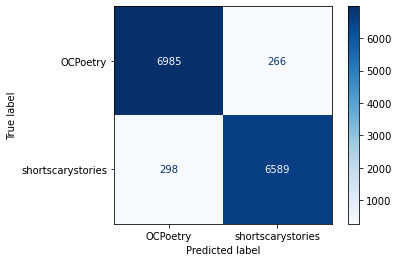

In [142]:
ConfusionMatrixDisplay.from_estimator(tfidf_all_features_model_lgbm, X_all_test, y_test, cmap = 'Blues')

### Examine misclassified poems

In [145]:
preds_best = tfidf_all_features_model_lgbm.predict(X_all_test)

In [115]:
wrong_preds = preds_best != y_test
with pd.option_context('max_colwidth', 200):
    display(X_all_test[wrong_preds].join(y_test)[['title_text', 'subreddit']].sample(10))

,title_text,subreddit
45495,if you can read thisit means you have the virus and I am sorry for spilling out to you like this through online. It's just that I don't want to be infected.,shortscarystories
25028,"I Hate DogsYou can listen to me perform my [spoken poem --- I was really, really hurt by a dog when I was younger. And now, whenever I spend time around a dog, I get scared that maybe they're goin...",OCPoetry
47856,"The Most Foul Thing Of AllYou think your life is good. It’s mostly devoid of threats, save for some hardships here and there, but nothing too big. You think you’re safe. But you’re not, because I ...",shortscarystories
28546,"Dad, will you read my sonnet? Oh...I tried to write a sonnet about Dad. Do you know how hard they are to create? Iambic what? I swear that I went mad. To count these syllables filled me with hate....",OCPoetry
26229,I was convinced I was going to burn the house down todayI was convinced I was going to burn the house down today. The hob wouldn't turn off and I was there alone. I was convinced something would c...,OCPoetry
12183,"Delay Your Son a MinuteIf you like this Poem, please leave an upvote and some feedback to satisfy my instant gratification. Thank you. Enjoy! Give us a minute. So we can come together. Hide his lu...",OCPoetry
55821,"Don't call me, I'll call youYeah it's me. Dude, do you know what time it is? Do you know this isn't an appropriate time to be calling me? I'm tired of you calling me like this. I don't care that y...",shortscarystories
38272,Sometimes love can be the death of you...🔪Enjoy these creepy tinder date stories gone wrong and **subscribe** for consistent nightmares 👫⚰️🎃,shortscarystories
15165,"UntitledDarkness has always been a part of my life. I guess that’s why I find comfort here. I let my demons seduce me. No longer fighting against the current. Relaxing now because, struggling only...",OCPoetry
16842,"Kingdom comeThe babe in wrap through her tattered vale was the sole glee on the causeway of dread. The knight's eyes turned wary with every trot His ringmail in hack, when a sword had run red. A t...",OCPoetry
